In [1]:
import numpy as np
import keras as k
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import layers as l

# Dataset Preparation

In [52]:
X_train = np.load('/content/drive/MyDrive/ts_data_raw.npz')['X_train']
y_train = np.load('/content/drive/MyDrive/ts_data_raw.npz')['y_train']
X_test = np.load('/content/drive/MyDrive/ts_data_raw.npz')['X_test']
y_test = np.load('/content/drive/MyDrive/ts_data_raw.npz')['y_test']
enc_vect = np.load('/content/drive/MyDrive/ts_data_raw.npz')['enc_dict']
enc_dict = {i:class_ for class_ ,i in zip(enc_vect, range(enc_vect.shape[0]))}

In [61]:
X_train = np.squeeze(X_train)
X_test = np.squeeze(X_test)

"""
PER FARE AMPLITUDE SCALING, sono stati fatti dei test, alla fine NON UTILIZZATA

meann = np.mean(X_train, axis=-1, keepdims=True)
std = np.std(X_train, axis=-1, keepdims=True)
X_train = X_train - meann
X_train = X_train / std
"""

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [4]:
X_train.shape

(7500, 1280, 1)

In [62]:
X_test.shape

(2500, 1280, 1)

## Model Selection

In [13]:
class FCN_ts(k.Model):
  """
  Rispetto alla versione utilizzata per le time series approssimate, è stato aggiunyo un layer con 128 nodi nella parte pienamente connessa. 
  Anche i valori di lambda per regolarizzare sono leggermente più alti.
  """
  def __init__(self):
    super().__init__()

    self.conv1 = l.Conv1D(12, 9, activation='relu', data_format='channels_last')
    self.batchnorm1 = l.BatchNormalization(axis=-1)
    self.batchnorm2 = l.BatchNormalization(axis=-1)
    self.batchnorm3 = l.BatchNormalization(axis=-1)
    self.conv2 = l.Conv1D(24, 9, activation='relu', data_format='channels_last', kernel_regularizer=k.regularizers.l2(0.06))
    self.conv3 = l.Conv1D(32, 9, activation='relu', data_format='channels_last', kernel_regularizer=k.regularizers.l2(0.06))

    self.drop = l.Dropout(0.55)
    self.hdrop = l.Dropout(0.8)

    self.pool = l.MaxPooling1D(data_format='channels_last')


    self.flat = l.Flatten()
    self.dense = l.Dense(128, activation='relu', kernel_regularizer=k.regularizers.l2(0.16))
    self.out = l.Dense(20, activation='softmax', kernel_regularizer=k.regularizers.l2(0.16))



  def call(self, x):
    x = self.conv1(x)
    x = self.batchnorm1(x)

    x = self.conv2(x)
    x = self.pool(x)
    x = self.batchnorm2(x)
    x = self.drop(x)

    x = self.conv3(x)
    x = self.pool(x)
    x = self.batchnorm3(x)
    x = self.hdrop(x)

    x = self.flat(x)
    x = self.dense(x)
    x= self.hdrop(x)
    x = self.out(x)

    return x

In [14]:
model = FCN_ts()
model.compile(
    optimizer=k.optimizers.Adam(learning_rate=0.0001), 
    loss=k.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "fcn_ts_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          multiple                  120       
                                                                 
 batch_normalization_12 (Ba  multiple                  48        
 tchNormalization)                                               
                                                                 
 batch_normalization_13 (Ba  multiple                  96        
 tchNormalization)                                               
                                                                 
 batch_normalization_14 (Ba  multiple                  128       
 tchNormalization)                                               
                                                                 
 conv1d_13 (Conv1D)          multiple                  2616      
                                                          

In [24]:
early_stopping = k.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=400,
    min_delta=0.0001,
    restore_best_weights=True
)

In [17]:
X_train_t = X_train[:6000]
y_train_t = y_train[:6000]

X_train_v = X_train[6000:]
y_train_v = y_train[6000:]

In [26]:
"""
TRAINING LOOP PRINCIPALE
Il modello è stato addestrato per 2000 epoche con un learning rate di 0.0001, successivamente per altre 1000 epoche con un learning rate di 0.00005.
Il tutto è stato fatto cambiando il codice di questa cella, eseguendola due volte.

"""


from keras import backend as kb
#kb.set_value(model.optimizer.learning_rate, 0.00005) # per cambiare il learning rate senza ricompilare il grafo

history = model.fit(
    x=X_train_t,
    y=y_train_t,
    epochs=2000,
    batch_size=256,
    validation_data=(X_train_v, y_train_v),
    callbacks=[early_stopping]
)

Epoch 1/1000
24/24 [==============================] - 1s 32ms/step - loss: 2.1232 - accuracy: 0.4312 - val_loss: 2.1662 - val_accuracy: 0.4300
Epoch 2/1000
24/24 [==============================] - 1s 29ms/step - loss: 2.1096 - accuracy: 0.4328 - val_loss: 2.1744 - val_accuracy: 0.4280
Epoch 3/1000
24/24 [==============================] - 1s 28ms/step - loss: 2.1098 - accuracy: 0.4310 - val_loss: 2.1792 - val_accuracy: 0.4213
Epoch 4/1000
24/24 [==============================] - 1s 29ms/step - loss: 2.1084 - accuracy: 0.4330 - val_loss: 2.1809 - val_accuracy: 0.4187
Epoch 5/1000
24/24 [==============================] - 1s 27ms/step - loss: 2.1172 - accuracy: 0.4345 - val_loss: 2.1740 - val_accuracy: 0.4233
Epoch 6/1000
24/24 [==============================] - 1s 27ms/step - loss: 2.1242 - accuracy: 0.4235 - val_loss: 2.1847 - val_accuracy: 0.4207
Epoch 7/1000
24/24 [==============================] - 1s 27ms/step - loss: 2.1420 - accuracy: 0.4192 - val_loss: 2.1793 - val_accuracy: 0.4233

### Logs Plots

In [28]:
# Per concatenare le diverse history date dai vari cicli di train
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

history_dict2 = history2.history
train_loss2 = history_dict2['loss']
val_loss2 = history_dict2['val_loss']
acc2 = history_dict2['accuracy']
val_acc2 = history_dict2['val_accuracy']


tot_acc = acc + acc2
tot_train_loss = train_loss + train_loss2
tot_val_loss = val_loss + val_loss2
tot_val_acc = val_acc + val_acc2


In [64]:
len(tot_acc)

2447

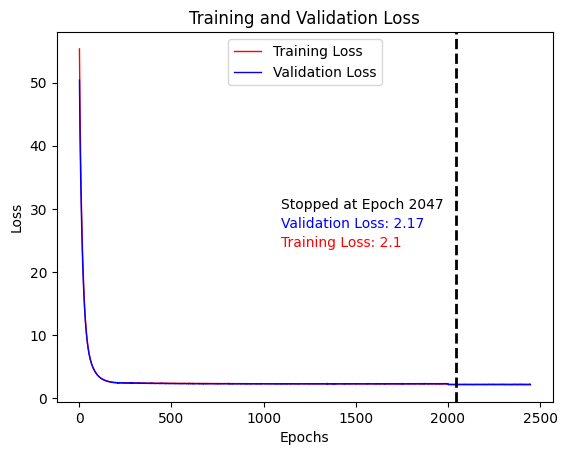

In [50]:




epochs = range(1, len(tot_acc)+1)

plt.plot(epochs, tot_train_loss, label='Training Loss', c='red', linewidth=1)
plt.plot(epochs, tot_val_loss, label='Validation Loss', c='blue', linewidth=1)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.axvline(x=np.argmax(tot_val_acc), c='black', linestyle='--', linewidth=2)
plt.text(x=np.argmax(tot_val_acc)-950, y=30, s=f'Stopped at Epoch {np.argmax(tot_val_acc) +1}')
plt.text(x=np.argmax(tot_val_acc)-950, y=27, s=f'Validation Loss: {round(tot_val_loss[np.argmax(tot_val_acc)], 2)}', c='blue')
plt.text(x=np.argmax(tot_val_acc)-950, y=24, s=f'Training Loss: {round(tot_train_loss[np.argmax(tot_val_acc)], 2)}', c='red')
plt.show()

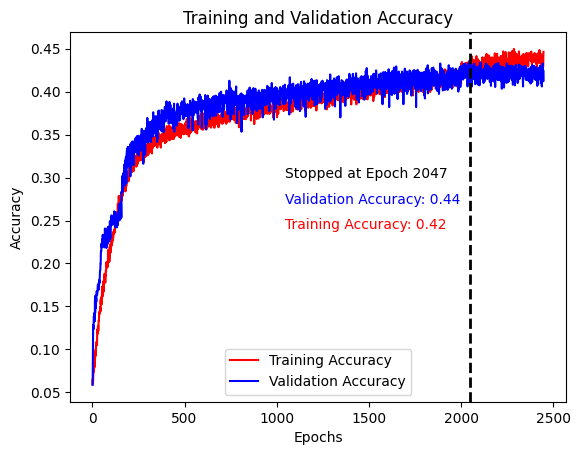

In [49]:
plt.plot(epochs, tot_acc, label='Training Accuracy', c='red')
plt.plot(epochs, tot_val_acc, label='Validation Accuracy', c='blue')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.axvline(x=np.argmax(tot_val_acc), c='black', linestyle='--', linewidth=2)
plt.text(x=np.argmax(tot_val_acc)-1000, y=0.30, s=f'Stopped at Epoch {np.argmax(tot_val_acc) +1}')
plt.text(x=np.argmax(tot_val_acc)-1000, y=0.27, s=f'Validation Accuracy: {round(tot_val_acc[np.argmax(tot_val_acc)], 2)}', c='blue')
plt.text(x=np.argmax(tot_val_acc)-1000, y=0.24, s=f'Training Accuracy: {round(tot_acc[np.argmax(tot_val_acc)], 2)}', c='red')
plt.show()

In [34]:
np.max(tot_val_acc), np.argmax(tot_val_acc)

(0.4359999895095825, 2046)

In [43]:
model.save('final_rats.keras')

In [45]:
model.save_weights('final_raw_weights')

In [44]:
np.savez('logs.npz', tot_acc=tot_acc, tot_train_loss=tot_train_loss, tot_val_acc=tot_val_acc, tot_val_loss=tot_val_loss)

In [53]:
def decode_y(y_enc, enc_dict):
    return [enc_dict[y] for y in y_enc]

## Validation Results

47/47 [==============================] - 1s 9ms/step


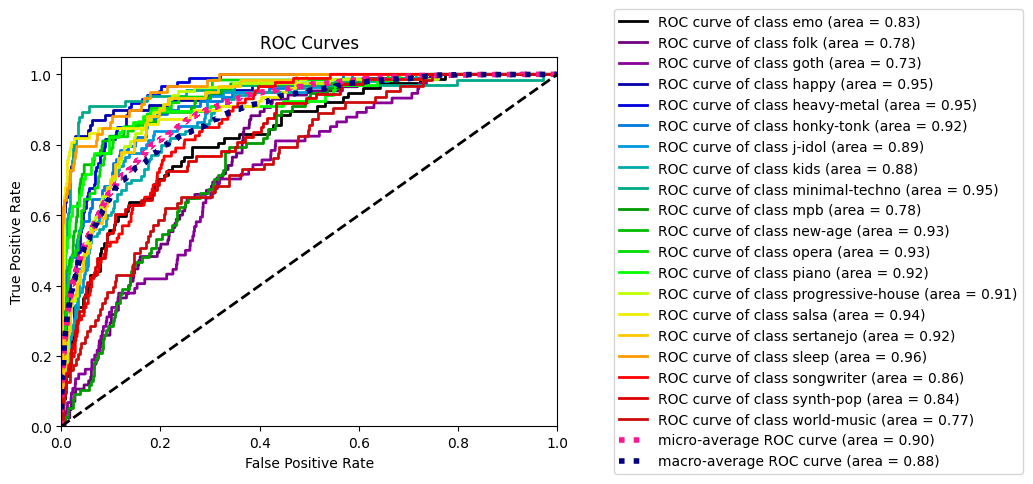

                   precision    recall  f1-score   support

              emo       0.48      0.21      0.29        77
             folk       0.40      0.05      0.08        85
             goth       0.00      0.00      0.00        74
            happy       0.73      0.70      0.71        69
      heavy-metal       0.44      0.69      0.54        87
       honky-tonk       0.41      0.58      0.48        79
           j-idol       0.40      0.31      0.35        81
             kids       0.42      0.45      0.43       100
   minimal-techno       0.63      0.79      0.70        66
              mpb       0.17      0.09      0.12        77
          new-age       0.54      0.53      0.53        74
            opera       0.44      0.56      0.50        62
            piano       0.57      0.55      0.56        67
progressive-house       0.48      0.30      0.37        84
            salsa       0.70      0.81      0.75        78
        sertanejo       0.27      0.61      0.38       

In [57]:
from sklearn.metrics import classification_report
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)

from scikitplot.metrics import plot_roc

y_prob = model.predict(X_train_v)
y_pred = y_prob.argmax(axis=-1)
plot_roc(decode_y(y_train_v, enc_dict), y_prob)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()
print(classification_report(decode_y(y_train_v, enc_dict), decode_y(y_pred, enc_dict)))

## Test Results

In [63]:

y_prob = model.predict(X_test)
y_pred = y_prob.argmax(axis=-1)
print(classification_report(decode_y(y_test, enc_dict), decode_y(y_pred, enc_dict)))

79/79 [==============================] - 0s 4ms/step
                   precision    recall  f1-score   support

              emo       0.35      0.11      0.17       125
             folk       0.20      0.02      0.04       125
             goth       0.17      0.01      0.02       125
            happy       0.73      0.66      0.69       125
      heavy-metal       0.37      0.56      0.45       125
       honky-tonk       0.38      0.61      0.47       125
           j-idol       0.39      0.35      0.37       125
             kids       0.39      0.58      0.47       125
   minimal-techno       0.67      0.72      0.69       125
              mpb       0.16      0.07      0.10       125
          new-age       0.43      0.43      0.43       125
            opera       0.44      0.55      0.49       125
            piano       0.56      0.51      0.53       125
progressive-house       0.41      0.27      0.33       125
            salsa       0.69      0.70      0.70       125
  